In [ ]:
import os
import time
import timeit

import cv2
import imutils
import numpy as np
from PIL import Image, ImageChops
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity

%matplotlib inline

In [43]:
def display(img,cmap='gray'):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap='gray')
    

In [44]:
# get cv2 object return cv2 object with no margin
def get_tv_frame(raw_cv2_frame):
    im_pil = Image.fromarray(raw_cv2_frame)
    bg = Image.new(im_pil.mode, im_pil.size, im_pil.getpixel((0, 0)))
    diff = ImageChops.difference(im_pil, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    dim1 = bbox[2] - bbox[0]
    dim2 = bbox[3] - bbox[1]
    # crop PIL object to bbox
    res = im_pil.crop(bbox)
    # use numpy to convert the pil_image into a numpy array
    numpy_image=np.array(res)

        #  O---- bbox[0] ---O
        #  |               |
        # bbox[1]      bbox[3]    
        #  |               |
        #  O---- bbox[2] ---O
    
    # convert to a openCV2 image, notice the COLOR_RGB2BGR which means that
    # the color is converted from RGB to BGR format
    opencv_image=cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR)
    display(opencv_image)
    print(bbox, type(bbox))
#     return opencv_image
    cv2.imwrite('process_results/get_tv_frame.png', opencv_image)
    return bbox

In [45]:
# from camera stream sample 2 images and find the differences, that should most likely be the TV the has changed frames.
# im1, im2 are cv2 objects.
# source: https://stackoverflow.com/questions/56183201/detect-and-visualize-differences-between-two-images-with-opencv-python

def diff_mask_2_frames(im1, im2):

    # before = cv2.imread('samples/test_diff/before2.png')
    # after = cv2.imread('samples/test_diff/after2.png')
    before = im1
    after = im2
    # Convert images to grayscale
    before_gray = cv2.cvtColor(before, cv2.COLOR_BGR2GRAY)
    after_gray = cv2.cvtColor(after, cv2.COLOR_BGR2GRAY)

    # Compute SSIM between two images
    (score, diff) = structural_similarity(before_gray, after_gray, full=True, gaussian_weights=True, sigma=2.5, use_sample_covariance=False, data_range=255)
    print("Image similarity", score)

    # The diff image contains the actual image differences between the two images
    # and is represented as a floating point data type in the range [0,1]
    # so we must convert the array to 8-bit unsigned integers in the range
    # [0,255] before we can use it with OpenCV
    diff = (diff * 255).astype("uint8")

    # Threshold the difference image, followed by finding contours to
    # obtain the regions of the two input images that differ
    thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    mask = np.zeros(before.shape, dtype='uint8')

    c = max(contours, key = cv2.contourArea)
    x,y,w,h = cv2.boundingRect(c)
    print(x,y,w,h)
    cv2.drawContours(mask, [c], 0, (0,255,0), -1)
    cv2.rectangle(mask,(x,y),(x+w,y+h),(155,155,155),1)

    cv2.circle(img=mask, center = (x,y), radius =5, color =(100,0,100), thickness=-1)
    # cv2.putText(mask,"1",(x,y),cv2.FONT_HERSHEY_COMPLEX,3,(250,250,10),2)

    cv2.circle(img=mask, center = (x+w,y+h), radius =5, color =(255,0,0), thickness=-1)
    # cv2.putText(mask,"2",(x+w,y+h),cv2.FONT_HERSHEY_COMPLEX,3,(250,250,10),2)

    cv2.circle(img=mask, center = (x+w,y), radius =5, color =(255,0,0), thickness=-1)
    # cv2.putText(mask,"3",(x+w,y),cv2.FONT_HERSHEY_COMPLEX,3,(250,250,10),2)

    cv2.circle(img=mask, center = (x, y+h), radius =5, color =(255,0,0), thickness=-1)
    # cv2.putText(mask,"4",(x,y+h),cv2.FONT_HERSHEY_COMPLEX,3,(250,250,10),2)

    display(mask)
    bbox = get_tv_frame(mask)
    cropped_frame= Image.open('samples/test_diff/before2.png').crop(bbox).save('process_results/cropped_frame.png')

        #  O---- bbox[1] ---O
        #  |               |
        # bbox[0]      bbox[2]
        #  |               |
        #  O---- bbox[3] ---O
    top_left= (bbox[0],bbox[1]) #[cols-1, rows-1]
    top_right= (bbox[2],bbox[1]) #[cols-1, rows-1]
    bottom_left= (bbox[0],bbox[3]) #[cols-1, rows-1]
    bottom_right= (bbox[2],bbox[3]) #[cols-1, rows-1]

    corners=[top_left, top_right, bottom_left, bottom_right]

    left_edge = bbox[0]
    top_edge= bbox[1]
    right_edge= bbox[2]
    bottom_edge= bbox[3]
    borders = [left_edge, top_edge, right_edge,bottom_edge]

    return corners, borders
        #  x,y-------(x+w,y)
        #   |         |
        #   |         |
        #   |         |
        #  (x, y+h)-------(x+w,y+h)


In [46]:
content_image = cv2.imread("samples/content/photo_2022-02-04_11-09-57.jpg",0)
ad_image = cv2.imread("samples/break/photo_2022-02-04_11-09-58.jpg",0)
test_image = cv2.imread("samples/test_set/test1.jpg",0)
current_frame=test_image
img_dims=current_frame.shape
print(img_dims)

(576, 1280)


Image similarity 0.8571893142987903
493 16 374 221
(488, 11, 873, 243) <class 'tuple'>
[(488, 11), (873, 11), (488, 243), (873, 243)]
[488, 11, 873, 243]


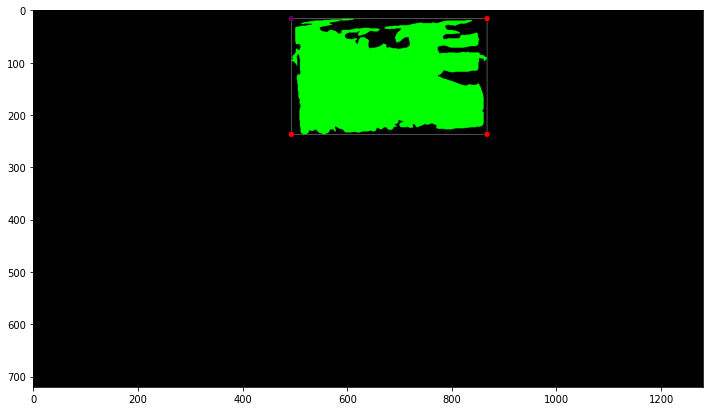

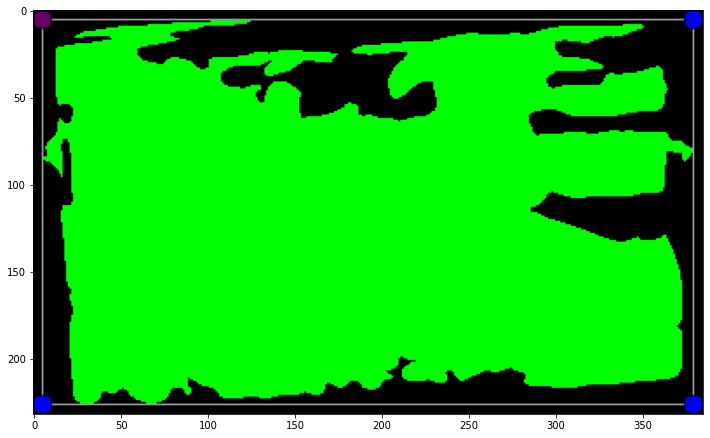

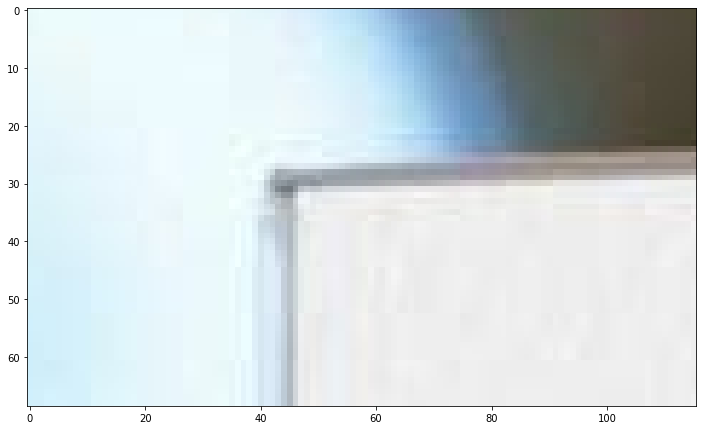

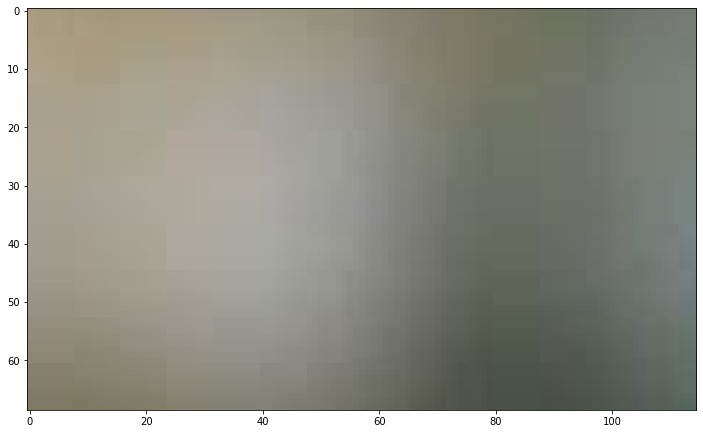

In [47]:
# TODO: sample 2 frames to get the ROI of the tv
sample1 = cv2.imread('samples/test_diff/before2.png')
sample2 = cv2.imread('samples/test_diff/after2.png')

# ROI
borders=[]
corners=[]
corners, borders = diff_mask_2_frames(sample1,sample2)
print(corners)
print(borders)
# from camera get TV fame
current_frame=cv2.imread('samples/test_set/test3.jpg')
# crop to roi
# frame_roi= current_frame[borders[0]:borders[2], borders[1]:borders[3]]
frame_roi= Image.fromarray(current_frame)
frame_roi=frame_roi.crop(borders)
frame_roi.save('process_results/frame_roi.png')
# cv2.imwrite('process_results/frame_roi.png', frame_roi)
# PIL to CV2
frame_roi_cv2 = np.array(frame_roi)
frame_roi_cv2 = frame_roi_cv2[:, :, ::-1].copy()
# get the top line only
top_strip = frame_roi_cv2[0:int(((frame_roi_cv2.shape[0])*0.3)), 0:frame_roi_cv2.shape[1]]
cv2.imwrite('process_results/top_strip.png', top_strip)

top_strip_right_qtr=top_strip[0:top_strip.shape[0],int(top_strip.shape[1]*0.7):top_strip.shape[1]]
cv2.imwrite('process_results/top_strip_right_qtr.png', top_strip_right_qtr)

top_strip_left_qtr=top_strip[0:top_strip.shape[0],0:int(top_strip.shape[1]*0.3)]
cv2.imwrite('process_results/top_strip_left_qtr.png', top_strip_left_qtr)

display(top_strip_right_qtr)
display(top_strip_left_qtr)

In [48]:
global counter
counter=0

def count_feature_matching_flann(current_frame_path, icon_img_path):
    global counter
    icon_img = cv2.imread(icon_img_path,0)
    gray_img = cv2.imread(current_frame_path,0)

    # Initiate SIFT detector
    #sift = cv2.xfeatures2d.SIFT_create()
    sift = cv2.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(gray_img,None)
    kp2, des2 = sift.detectAndCompute(icon_img,None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params,search_params)

    matches = flann.knnMatch(des1,des2,k=2)

    # Need to draw only good matches, so create a mask
    matchesMask = [[0,0] for i in range(len(matches))]

    # ratio test
    for i,(match1,match2) in enumerate(matches):
        if match1.distance < 0.7*match2.distance:
            matchesMask[i]=[1,0]

    draw_params = dict(matchColor = (0,255,0),
                       singlePointColor = (255,0,0),
                       matchesMask = matchesMask,
                       flags = 0)

    flann_matches = cv2.drawMatchesKnn(gray_img,kp1,icon_img,kp2,matches,None,**draw_params)
    display(flann_matches)
    cv2.imwrite('process_results/flann_matches_{}.png'.format(counter), flann_matches)
    counter=counter+1

    return flann_matches

In [49]:
count_feature_matching_flann('process_results/top_strip_left_qtr.png','channels_icon/break/right/13_15 04.02.2022(2f0).png')
count_feature_matching_flann('process_results/top_strip_left_qtr.png','channels_icon/break/right/13_15 04.02.2022(2f3).png')
count_feature_matching_flann('process_results/top_strip_left_qtr.png','channels_icon/break/right/13_16 04.02.2022(2f5).png')
count_feature_matching_flann('process_results/top_strip_left_qtr.png','channels_icon/break/right/13_16 04.02.2022(2f6).png')
count_feature_matching_flann('process_results/top_strip_left_qtr.png','channels_icon/break/right/13_16 04.02.2022(2f8).png')


AttributeError: module 'cv2' has no attribute 'xfeatures2d'

In [ ]:
count_feature_matching_flann('process_results/top_strip_right_qtr.png','channels_icon/break/right/13_15 04.02.2022(2f0).png')
count_feature_matching_flann('process_results/top_strip_right_qtr.png','channels_icon/break/right/13_15 04.02.2022(2f3).png')
count_feature_matching_flann('process_results/top_strip_right_qtr.png','channels_icon/break/right/13_16 04.02.2022(2f5).png')
count_feature_matching_flann('process_results/top_strip_right_qtr.png','channels_icon/break/right/13_16 04.02.2022(2f6).png')
count_feature_matching_flann('process_results/top_strip_right_qtr.png','channels_icon/break/right/13_16 04.02.2022(2f8).png')

In [ ]:
def count_feature_matching_orb(gray_img, icon_img_path):
    icon_img = cv2.imread(icon_img_path,0)

    # Initiate ORB detector
    orb = cv2.ORB_create()
    # find the keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(icon_img,None)
    kp2, des2 = orb.detectAndCompute(gray_img,None)

    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors.
    matches = bf.match(des1,des2)

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)
    # Draw first 25 matches.
    show_matches = cv2.drawMatches(icon_img,kp1,gray_img,kp2,matches[:25],None,flags=2)
    display(show_matches)
    return matches



# compare dir elements to the given image, returns the number of matches of the best image.
def feature_matching_in_dir(gray_img, dir):
    listOfFiles = os.listdir(dir)
    list_of_results=[]
    list_of_results_flann=[]
    for icon_img_path in listOfFiles:
        list_of_results.append(count_feature_matching_orb(gray_img, icon_img_path))
        list_of_results_flann.append(count_feature_matching_flann(gray_img, icon_img_path))

    print("ORB list max: {}  Flann list max: {}\n".format(np.max(list_of_results),np.max(list_of_results_flann)))
    print("ORB list: {}  Flann list: {}\n".format(list_of_results,list_of_results_flann))
    return np.max(list_of_results)


In [33]:
# compares the corner from the TV to the known examples to check if it's ad-time or not
# by feature matching
def check_if_ad_time_by_corner(sub_strip_grey, corner):
    matches_ads_right=0
    matches_content_right=0
    matches_content_left=0

    if corner=='right':
        ad_path= r'channels_icon/break/right'
        content_path= r'channels_icon/break/right'

        matches_ads_right=feature_matching_in_dir(sub_strip_grey, ad_path)
        matches_content_right=feature_matching_in_dir(sub_strip_grey, content_path)

    elif corner=='left':
        #ad_path= r'channels_icon/break/left' # no indicator on left when no ads
        content_path= r'channels_icon/break/left'
        matches_content_left=feature_matching_in_dir(sub_strip_grey, content_path)

    ad_avg= matches_ads_right
    content_avg= (matches_content_right+matches_content_left)/2

    if ad_avg>content_avg:
        # means it's likely to be ad-time
        print("That's an ad\n")

    else:
        print("No ad\n")

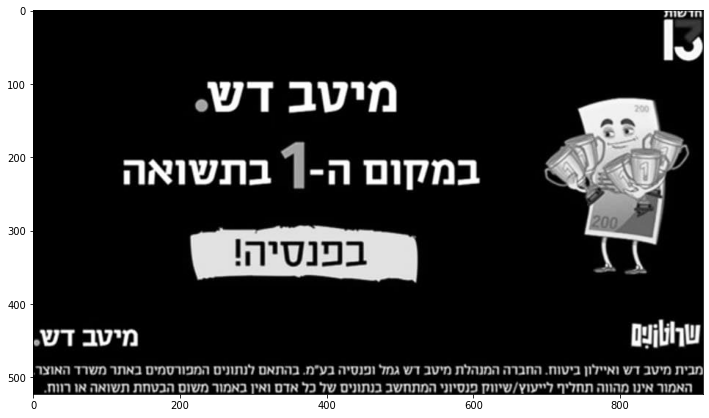

In [31]:
check_if_ad_time_by_corner(top_strip_right_qtr, 'right')
check_if_ad_time_by_corner(top_strip_left_qtr, 'left')

error: OpenCV(4.5.4-dev) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [36]:
# before = cv2.imread('samples/test_diff/before2.png')
# after = cv2.imread('samples/test_diff/after2.png')
#
# #Read the book image
# book  = cv2.imread('samples/test_diff/before2.png')
# #four corners of the book in the image
# x,y,w,h = diff_mask_2_frames(before, after)
#
#         #   4-------  3
#         #   |         |
#         #   |         |
#         #   |         |
#         #   1 ------- 2
# # pts_book = np.array([[x, y+h], [x+w,y+h ], [x+w,y], [x,y]])
# pts_book = np.array([[y+h, x], [y+h,x+w ], [y,x+w], [y,x]])
#
# #general aspect ratio of books are 16:9 for so we choose the size (1600, 900)
# pts_correct = np.array([[0, 0], [899, 0], [899, 1599], [0, 1599]])
#
# #calculate homography from book image to size(300, 400)
# homorgaphyMat, status = cv2.findHomography(pts_book, pts_correct)
#
# #warp book for perspective correction (300, 400)
# result = cv2.warpPerspective(book, homorgaphyMat, (300, 400))
#
# display(book)
# display(result)


error: OpenCV(4.5.4-dev) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


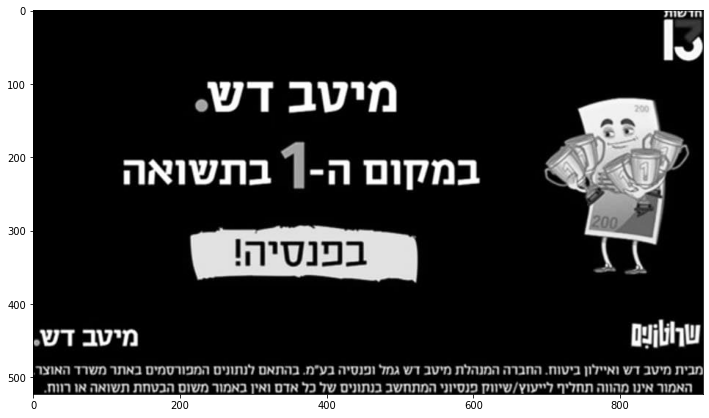

In [31]:
# # source: https://www.geeksforgeeks.org/python-opencv-affine-transformation/
#         #   [0,0] (x,y)-------  [cols-1,0] (x+w,y)
#         #   |                                   |
#         #   |                                   |
#         #   |                                   |
#         #   [0, rows-1] (x,y+h) ------- [cols-1, rows-1] (x+w,y+h)
#
#         # to
#         #   [0,0]-------  [1599,0]
#         #   |                  |
#         #   |                  |
#         #   |                  |
#         #   [0, 899]------- [1599, 899]
#
# before = cv2.imread('samples/test_diff/before2.png')
# after = cv2.imread('samples/test_diff/after2.png')
#
# #four corners of the book in the image
# x,y,w,h = diff_mask_2_frames(before, after)
# rows = h
# cols= w
#
# pts1 = np.float32([[x,y],
#                    [x+w,y],
#                    [x, y+h]
#                    #[x+w,y+h]
#                    ])
#
# pts2 = np.float32([[0, 0],
#                   [1599, 0],
#
#                    [0, 899]
#                    #[1599, 899]
#                    ])
#
# M = cv2.getAffineTransform(pts1, pts2)
# dst = cv2.warpAffine(before, M, (cols, rows))
#
# plt.subplot(121)
# display(before)
# plt.imshow(before)
# plt.title('Input')
#
# plt.subplot(122)
# plt.imshow(dst)
# plt.title('Output')
#
# plt.show()